In [92]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


#### 데이터 준비

In [93]:
df = pd.read_csv('/home/user/exercise_j/TwitterXAPI/10000Tweets_Crypto_data.csv')

In [94]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.sort_values(by='created_at', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,created_at,text,ticker,sentiment_score
0,2010-10-30,Absolutely Stunning Vector Inspiration http://...,BTC,0.00
1,2010-11-01,@yogavenger Thanks for the RTs,BTC,0.75
2,2010-11-03,Massive Social Media Icon Collection http://bi...,BTC,0.00
3,2010-11-04,Is the User Mastermind Behind Web Design? http...,BTC,0.00
4,2010-11-05,Everyone give a big happy birthday to @robertb...,BTC,0.00


#### (가장 데이터가 많이 존재하는)최근 6개월의 데이터로 input_data 설정
##### 2023.06.01 ~ 2023.12.31

In [95]:
start_date = '2023-06-01'
end_date = '2023-12-31'
filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])
filtered_df

,created_at,text,ticker,sentiment_score
0,2023-06-01,The Fed and Treasury are using interest income...,BTC,0.8
1,2023-06-01,RT @vdWijden: Are you interested in core devel...,ETH,0.0
2,2023-06-01,RT @TMIYChao: Ethereum is for everyone and the...,ETH,0.0
3,2023-06-01,@gregthegreek Maybe we should just airdrop (bi...,ETH,0.0
4,2023-06-02,@lightclients There might be too much alpha in...,ETH,0.0
...,...,...,...,...
4437,2023-12-31,RT @xrpmemeguy: Do you know why Patrick McHenr...,XRP,0.0
4438,2023-12-31,"XRP ETF / Ripple Win , United States Of Corrup...",XRP,0.0
4439,2023-12-31,"RT @zerohedge: ""We Are Going To See 'Collision...",BTC,0.0
4440,2023-12-31,My Theory: FTX was created for the specific pu...,SOL,-1.0


1. 티커별로 분류
2. 각 티커별로 input_data 생성
 - input_data의 구성은 created_at sentiment_score

In [96]:
# 1. 티커별로 데이터프레임을 분류
tickers = filtered_df['ticker'].unique()
ticker_dfs = {ticker: filtered_df[filtered_df['ticker'] == ticker] for ticker in tickers}

# 2. 각 티커에 대한 input_data를 생성
# input_data는 'created_at'과 'sentiment_score'만 포함
input_data = {ticker: filtered_df[['created_at', 'sentiment_score']] for ticker, filtered_df in ticker_dfs.items()}

input_data['ETH'] 

,created_at,sentiment_score
1,2023-06-01,0.00
2,2023-06-01,0.00
3,2023-06-01,0.00
4,2023-06-02,0.00
11,2023-06-05,0.25
...,...,...
4400,2023-12-30,-0.50
4411,2023-12-30,-0.60
4419,2023-12-30,-0.50
4427,2023-12-31,0.00


In [97]:
grouped_input_data = {}
for ticker, df in ticker_dfs.items():
    grouped_df = df.groupby('created_at')['sentiment_score'].sum().reset_index()
    grouped_input_data[ticker] = grouped_df

grouped_input_data

{'BTC':     created_at  sentiment_score
 0   2023-06-01             0.80
 1   2023-06-04             0.00
 2   2023-06-06             1.50
 3   2023-06-07             0.00
 4   2023-06-09             0.00
 ..         ...              ...
 175 2023-12-27             1.65
 176 2023-12-28            -0.50
 177 2023-12-29             0.10
 178 2023-12-30            -1.00
 179 2023-12-31             0.45
 
 [180 rows x 2 columns],
 'ETH':     created_at  sentiment_score
 0   2023-06-01             0.00
 1   2023-06-02             0.00
 2   2023-06-05             0.50
 3   2023-06-06             0.50
 4   2023-06-08             5.95
 ..         ...              ...
 171 2023-12-27            -1.65
 172 2023-12-28             0.00
 173 2023-12-29            -2.00
 174 2023-12-30            -1.60
 175 2023-12-31            -0.50
 
 [176 rows x 2 columns],
 'UNI':    created_at  sentiment_score
 0  2023-06-02            -1.00
 1  2023-06-03            -0.75
 2  2023-06-04             0.80
 3  2

#### 각 크립토 거래 종가, 거래 규모 데이터 (2023.06.01 ~ 2023.12.31)

In [98]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [99]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    del df['변동 %']
    del df['고가']
    del df['시가']
    del df['저가']
    
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']

    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


In [100]:
filtered_dfs['ETH']

,종가,거래량,created_at
0,"2,281.90",232.62K,2023-12-31
1,"2,291.70",219.92K,2023-12-30
2,"2,299.24",475.37K,2023-12-29
3,"2,344.47",626.91K,2023-12-28
4,"2,378.63",577.27K,2023-12-27
...,...,...,...
360,"1,250.95",289.49K,2023-01-05
361,"1,256.92",504.28K,2023-01-04
362,"1,214.57",219.98K,2023-01-03
363,"1,213.93",270.72K,2023-01-02


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [101]:
print(grouped_input_data.keys())
print(filtered_dfs.keys())

dict_keys(['BTC', 'ETH', 'UNI', 'BNB', 'DOT', 'XRP', 'SOL', 'FTT'])
dict_keys(['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI'])


In [102]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

In [103]:
merged_dfs = {}
for ticker in ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP','UNI']:
    merged_df = pd.merge(filtered_dfs[ticker], grouped_input_data[ticker], on='created_at', how='outer')
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)
    merged_df['거래량'] = merged_df['거래량'].apply(convert_volume)
    merged_dfs[ticker] = merged_df

# 결과 출력
merged_dfs

{'BTC':            종가       거래량 created_at  sentiment_score
 0    42,272.5   35580.0 2023-12-31             0.45
 1    42,136.7   35180.0 2023-12-30            -1.00
 2    42,072.4   60980.0 2023-12-29             0.10
 3    42,581.1   49840.0 2023-12-28            -0.50
 4    43,446.5   50100.0 2023-12-27             1.65
 ..        ...       ...        ...              ...
 360  16,829.8  178960.0 2023-01-05             0.00
 361  16,852.1  247390.0 2023-01-04             0.00
 362  16,674.2  178730.0 2023-01-03             0.00
 363  16,674.3  136030.0 2023-01-02             0.00
 364  16,618.4  107840.0 2023-01-01             0.00
 
 [365 rows x 4 columns],
 'ETH':            종가       거래량 created_at  sentiment_score
 0    2,281.90  232620.0 2023-12-31            -0.50
 1    2,291.70  219920.0 2023-12-30            -1.60
 2    2,299.24  475370.0 2023-12-29            -2.00
 3    2,344.47  626910.0 2023-12-28             0.00
 4    2,378.63  577270.0 2023-12-27            -1.65
 ..  

#### 각 티커별 데이터 변환 및 스케일링

#### MinMax scaler

processed_data2 = {}
scaler = MinMaxScaler()
for ticker, df in merged_dfs.items():
    # '종가' 열 처리: 쉼표 제거, 실수형 변환
    prices = df['종가'].replace(',', '', regex=True).astype(float).values.reshape(-1, 1)

    # '거래량' 열 처리
    volumes = df['거래량'].values.reshape(-1, 1)

    # 'sentiment_score' 열 처리
    sentiments = df['sentiment_score'].values.reshape(-1, 1)

    # (p_t, v_t, s_t) 형태로 결합
    data = np.hstack((prices, volumes, sentiments))
    # 데이터를 표준화
    data = scaler.fit_transform(data)
    
    processed_data2[ticker] = data

data2 = processed_data2['BNB']

In [83]:
scaler = MinMaxScaler()

processed_data = {}

for ticker, df in merged_dfs.items():
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.set_index('created_at', inplace=True)
    
    # '종가' 열이 문자열이라면 쉼표 제거 후 로그 변환을 수행
    if df['종가'].dtype == 'O':  # 'O'는 객체(object) 타입을 의미합니다.
        prices = df['종가'].str.replace(',', '').astype(float)
    else:
        prices = df['종가'].astype(float)
    
    # 로그 변환
    prices_log = np.log1p(prices)

    # 나머지 열도 동일하게 처리
    volumes_log = np.log1p(df['거래량'].astype(float))
    sentiments = df['sentiment_score']
    
    # 모든 로그 변환된 데이터를 MinMaxScaler를 사용하여 스케일링
    features = np.stack((prices_log, volumes_log, sentiments), axis=1)
    scaled_features = scaler.fit_transform(features)
    
    processed_data[ticker] = scaled_features

In [104]:
processed_data = {}

for ticker, df in merged_dfs.items():
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.set_index('created_at', inplace=True)
    
    # '종가' 열이 문자열이라면 쉼표 제거 후 로그 변환을 수행
    if df['종가'].dtype == 'O':  # 'O'는 객체(object) 타입을 의미합니다.
        prices = df['종가'].str.replace(',', '').astype(float)
    else:
        prices = df['종가'].astype(float)
    prices_log = np.log1p(prices)

    sentiments = df['sentiment_score']
    volumes_log = np.log1p(df['거래량'].astype(float))

    features = np.stack((prices_log, volumes_log, sentiments), axis=1)
    processed_data[ticker] = features

In [14]:
processed_data

{'BTC': array([[10.65191569, 10.47956707,  0.45      ],
        [10.64869811, 10.46826144, -1.        ],
        [10.64717099, 11.01831762,  0.1       ],
        ...,
        [ 9.72167786, 12.09363716,  0.        ],
        [ 9.72168386, 11.82063808,  0.        ],
        [ 9.71832597, 11.5884132 ,  0.        ]]),
 'ETH': array([[ 7.73320184, 12.3571658 , -0.5       ],
        [ 7.73748544, 12.30102367, -1.6       ],
        [ 7.74076874, 13.07185083, -2.        ],
        ...,
        [ 7.10296838, 12.30129646,  0.        ],
        [ 7.10244174, 12.50884405,  0.        ],
        [ 7.0913427 , 11.74895365,  0.        ]]),
 'BNB': array([[ 5.74620319, 13.42624011,  0.        ],
        [ 5.76079273, 13.25514624,  0.        ],
        [ 5.75130199, 14.1731857 , -0.6       ],
        ...,
        [ 5.51019773, 11.65988751,  0.        ],
        [ 5.50614421, 12.06888314,  0.        ],
        [ 5.50288953, 11.60869917,  0.        ]]),
 'DOT': array([[ 2.21963817, 16.45599551,  0.       

#### 데이터셋 생성
##### time_steps = 7일

In [67]:
def create_dataset_with_updated_Q(data, start_index, end_index, time_steps=30):
    dataX, dataY = [], []
    # 첫 번째 예상 수익률 Q_t-1을 0으로 초기화

    for i in range(start_index, end_index):
        # 현재 time_steps 만큼의 데이터
        a = data[(i - time_steps):i, :]
        # 다음 시점의 가격을 통해 Q_t를 계산
        current_price = data[i, 0]
        prior_price = data[i - 1, 0]
    
        # a에 최신 Q_t_minus_1 추가

        dataX.append(a)
        dataY.append(current_price)
        # 다음 루프를 위해 Q_t-1 업데이트

    return np.array(dataX), np.array(dataY)

# 데이터셋 준비
time_steps = 30
start_index = 151
end_index = 365

#### LSTM 함수 정의

In [55]:
# 예측 수행 함수
def lstm_predict(X, model):
    predicted_returns = []
    for i in tqdm(range(len(X)), desc="Predicting"):
        # 모델을 사용하여 예측
        predicted_return = model.predict(np.expand_dims(X[i], axis=0), verbose=0)
        predicted_returns.append(predicted_return[0,0])
    return predicted_returns


#### LSTM 완성
##### 결과 비교
예시 : ETH

In [85]:
data = processed_data['BNB']
data = np.flipud(data)

data

array([[0.33066212, 0.03281441, 0.76712329],
       [0.33686293, 0.15575763, 0.76712329],
       [0.34458566, 0.04648994, 0.76712329],
       ...,
       [0.80393641, 0.71794525, 0.68493151],
       [0.82201812, 0.47268089, 0.76712329],
       [0.7942222 , 0.5183905 , 0.76712329]])

In [86]:
X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)

# 모델 정의
model = Sequential()

# 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
model.add(LSTM(2000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

# Dropout을 추가하여 과적합 방지
# model.add(Dropout(0.2))

# 두 번째 LSTM 층 추가
# model.add(LSTM(1000, return_sequences=True))

# model.add(LSTM(50, return_sequences=True))

# model.add(LSTM(100, return_sequences=True))

# 또 다른 Dropout 층
# model.add(Dropout(0.2))

# 세 번째 LSTM 층 추가
# model.add(LSTM(1000))

# 마지막 Dense 층 추가. 출력층
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=500, batch_size=32, verbose=1)

predicted_returns = lstm_predict(X, model)


Epoch 1/500
7/7 [==============================] - 1s 14ms/step - loss: 0.2639
Epoch 2/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0337
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0201
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0142
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0113
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0081
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0070
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0069
Epoch 9/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 10/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0060
Epoch 11/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0056
Epoch 12/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0055
Epoch 13/500
7/7 [==============================]

Predicting: 100%|██████████| 214/214 [00:11<00:00, 19.10it/s]


#### 그래프 생성

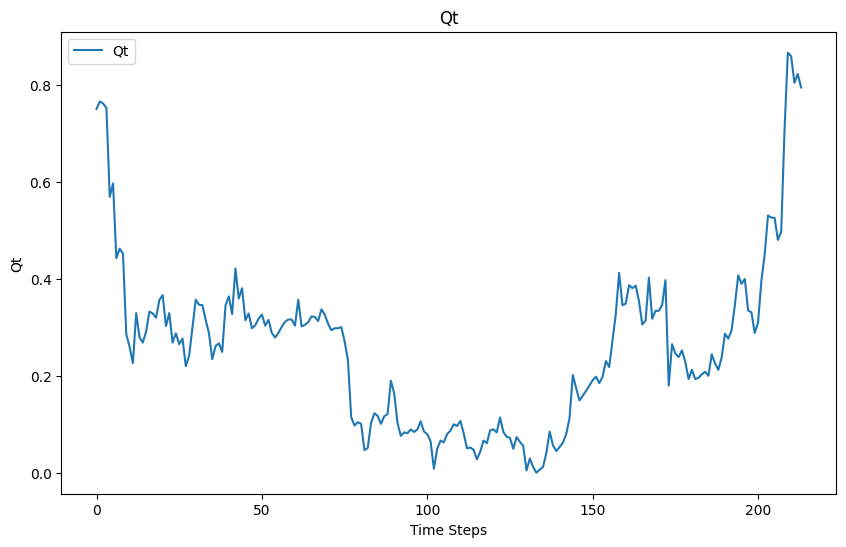

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

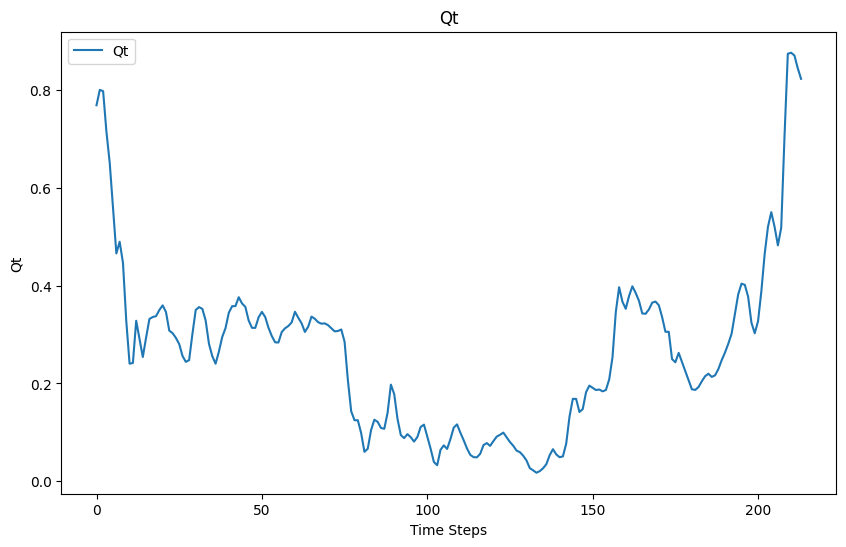

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

In [105]:
results = {}
for ticker, data in processed_data.items():
    data = np.flipud(data)
    # 입력 데이터셋 생성
    X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)
    # 모델 정의
    model = Sequential()

    # 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
    model.add(LSTM(1000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

    # Dropout을 추가하여 과적합 방지
    # model.add(Dropout(0.2))

    # 두 번째 LSTM 층 추가
    # model.add(LSTM(1000, return_sequences=True))

    # 또 다른 Dropout 층
    # model.add(Dropout(0.2))

    # 세 번째 LSTM 층 추가
    # model.add(LSTM(1000))

    # 마지막 Dense 층 추가. 출력층
    model.add(Dense(1))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 학습
    model.fit(X, y, epochs=200, batch_size=32, verbose=0)

    predicted_returns = lstm_predict(X, model)
    results[ticker] = {
        'predicted_returns': predicted_returns
    }
    

Predicting: 100%|██████████| 214/214 [00:10<00:00, 19.66it/s]


#### Verification을 위해 predicted returns 분리 후 pickle로 같은 디렉토리에 저장

In [106]:
# 각 티커별 predicted returns를 저장할 딕셔너리
predicted_returns_by_ticker = {}

for ticker, result in results.items():
    predicted_returns_by_ticker[ticker] = result['predicted_returns']

# 결과 출력
for ticker, predicted_returns in predicted_returns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print("Predicted Returns:", predicted_returns)
    print()

Ticker: BTC
Predicted Returns: [10.269896, 10.280716, 10.279274, 10.265469, 10.262824, 10.269057, 10.296468, 10.297992, 10.279939, 10.276631, 10.279178, 10.286077, 10.287959, 10.28466, 10.278468, 10.278648, 10.281179, 10.278078, 10.279143, 10.28342, 10.293479, 10.302893, 10.303565, 10.306552, 10.30375, 10.303821, 10.302882, 10.302743, 10.299159, 10.295199, 10.313189, 10.295325, 10.286941, 10.291442, 10.288008, 10.282281, 10.276598, 10.274957, 10.267087, 10.263892, 10.269762, 10.269447, 10.270833, 10.281854, 10.282722, 10.261573, 10.247746, 10.254337, 10.275672, 10.276958, 10.257717, 10.25771, 10.250346, 10.25224, 10.249776, 10.251739, 10.246004, 10.248989, 10.2552805, 10.251767, 10.256238, 10.255988, 10.249506, 10.269963, 10.27436, 10.280943, 10.27885, 10.264538, 10.264779, 10.281152, 10.271086, 10.261977, 10.264255, 10.256523, 10.254296, 10.265037, 10.253298, 10.263811, 10.271054, 10.265987, 10.263745, 10.258925, 10.261349, 10.273979, 10.288716, 10.278306, 10.275914, 10.265715, 10.283

In [107]:
with open('/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/Crypto_ECM-LSTM/q_vector_epoch_minmax_price_log.pkl', 'wb') as f:
    pickle.dump(predicted_returns_by_ticker, f)

: 